In [1]:
import galarp as grp

grp.pyplot_style()
cmap = grp.lavender_cmap(step_1=50)

import numpy as np

from astropy import units as u
from astropy.table import Table

from gala.units import galactic
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt

## Goal: Generate the following figures:

1. $M_{\text{gas}}$ vs $t$
2. $R_{\text{strip}}$ vs $t$
3. $v_z$ vs $z$ as a matrix plot

In [2]:
jz2023_satellite = grp.builtins.JZ2023_Satellite()          # Satellite grav potential
jz2023_cluster_potential = grp.builtins.JZ2023_1e14()       # Host cluster potential
jz2023_cluster_ic = grp.builtins.JZ2023_1e14_IC()           # Satellite galaxy initial conditions

mass_profile = grp.gen_mass_profile(jz2023_satellite)



In [3]:
# Setup initial particle grid

# pp = particles=grp.ExponentialDistribution(h_R=jz2023_satellite["gas"].parameters["a"].value,
#                                                                   h_z=jz2023_satellite["gas"].parameters["b"].value,
#                                                                   n_particles=10000)
# pp.save_positions("temp/positions.npy")


particles = grp.ParticleSet(particles=grp.ParticleDistribution.from_file("temp/positions.npy"))

particles.generate(mass_profile=mass_profile)

# particles = grp.ExponentialGrid(h_R=jz2023_satellite["gas"].parameters["a"],
#                            h_z=jz2023_satellite["gas"].parameters["b"],
#                            n_particles=10000)

# # Only run generate_exponential_positions if temp/positions.npy does not exist

# # positions = grp.generate_exponential_positions(h_R=particles.h_R, h_z=particles.h_z,
# #                                                n_particles=particles.n_particles,
# #                                                Rmax=particles.Rmax, zmax=particles.zmax,
# #                                                outname="temp/positions.npy")

# particles.generate(mass_profile=mass_profile, positions="temp/positions.npy")


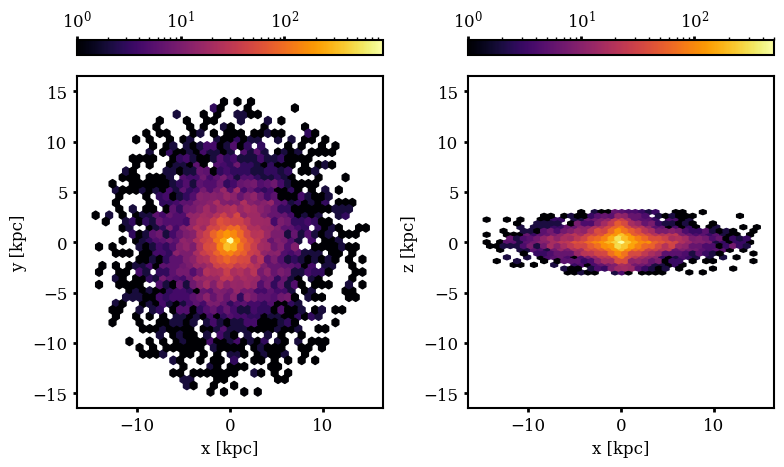

In [4]:

particles.particles.plot_positions()

In [5]:
inc = 45

wind = grp.InterpolatedStrengthWind().from_table("ICMinflow_1e14_group_profile_45degree_wind_stacked_pericenter_data.in",
                                         t_key="col1", vel_keys=["col4", "col5", "col6"],
                                         inc=np.deg2rad(inc))

shadow = grp.UniformShadow(damping=0.4, R_disk = 8 * u.kpc, zmin=0.5 * u.kpc, phi=np.deg2rad(inc), dynamic=True)


## Integrate the RP event with GalaRP

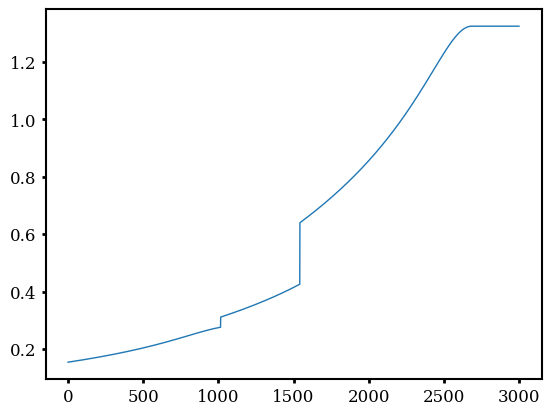

In [6]:
inc = 45

wind = grp.InterpolatedStrengthWind().from_table("ICMinflow_1e14_group_profile_45degree_wind_stacked_pericenter_data.in",
                                        t_key="col1", vel_keys=["col4", "col5", "col6"],
                                        inclination=np.deg2rad(inc))

rho = grp.InterpolatedDensity().from_table("ICMinflow_1e14_group_profile_45degree_wind_stacked_pericenter_data.in",
                                        t_key="col1", rho_key="col2")

shadow = grp.UniformShadow(damping=0.4, R_disk = 8 * u.kpc, zmin=0.5 * u.kpc, phi=np.deg2rad(inc))



ts = np.arange(0, 3000, 1) * u.Myr

vs = wind.evaluate_arr(ts).T
v_tot = np.sqrt(np.sum(vs**2, axis=0))

rhos = rho.evaluate_arr(ts)

plt.plot(ts, v_tot)

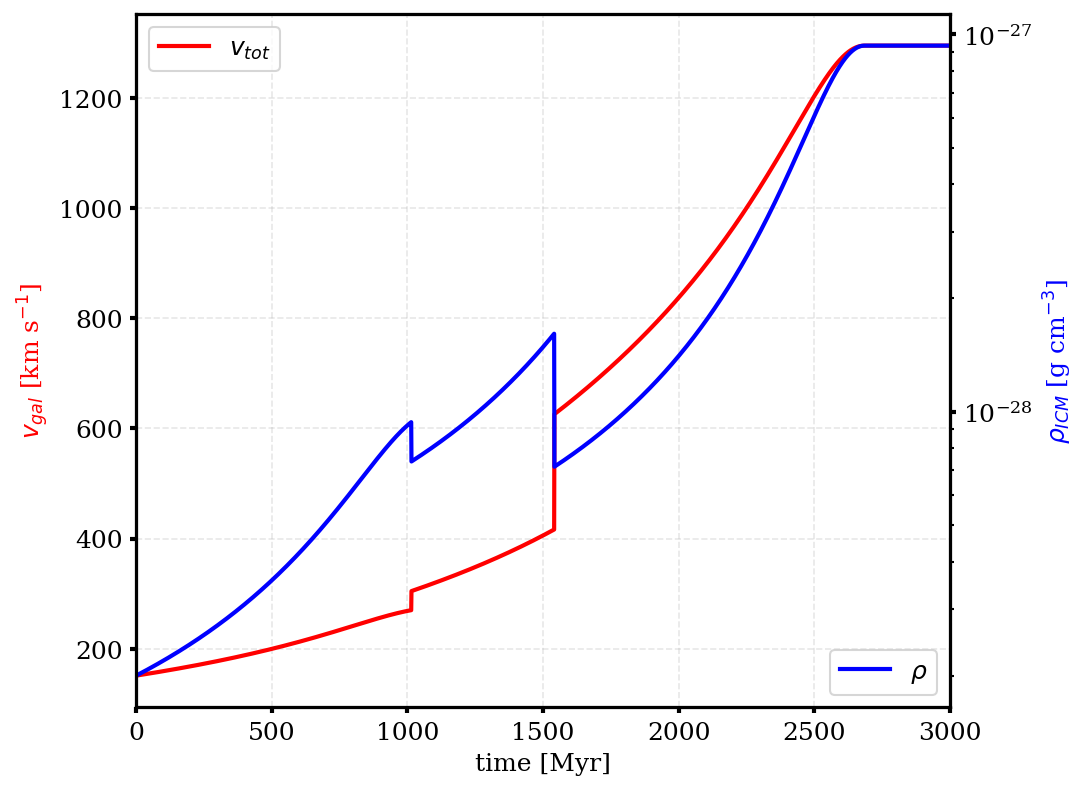

In [7]:
fig,ax = plt.subplots(1, 1, figsize=(7,6),dpi=150)
plt.grid(True, which='both', alpha=0.3, linestyle='--')

plt.xlabel('time [Myr]')
plt.ylabel(r'$v_{gal}$ [km s$^{-1}$]',color='r')

plt.plot(ts, v_tot * (u.kpc/u.Myr).to(u.km/u.s), label=r'$v_{tot}$' ,color='r', lw=2)

plt.xlim(0,3000)

plt.legend(loc='upper left')
ax2 = ax.twinx()

ax2.plot(ts, rhos, label=r'$\rho$',color='b', lw=2)

ax2.set_yscale('log')
ax2.set_ylabel(r'$\rho_{ICM}$ [g cm$^{-3}$]',color='b')
ax2.legend(loc='lower right')

#plt.savefig('ICM_profile_stack_1e14_pericenter_wind.png')
plt.show()

In [8]:
sim = grp.RPSim(potential=jz2023_satellite, wind=wind, shadow=shadow)
orbits = sim.run(particles, integration_time=5 * u.Gyr, dt=5 * u.Myr)


--------------------------------------------------------------------------------
------ Running GALA sim with  8.18e-01 kpc / Myr  wind at  0.79  degrees -------
---- Running for 5.0 Gyr  at a timestep of  5.0 Myr  (1.0 Gyr / Myr steps) -----
--------------------------------------------------------------------------------
---------------------- Container contains 10000 particles ----------------------
- Each cloud has a mass of  1.0e+05 solar masses  and a radius of  50.00 pc   --
------------- This corresponds to a density of 5.41e-23 g / cm3   --------------
--------------------------------------------------------------------------------


100%|██████████| 999/999 [00:14<00:00, 70.69it/s]


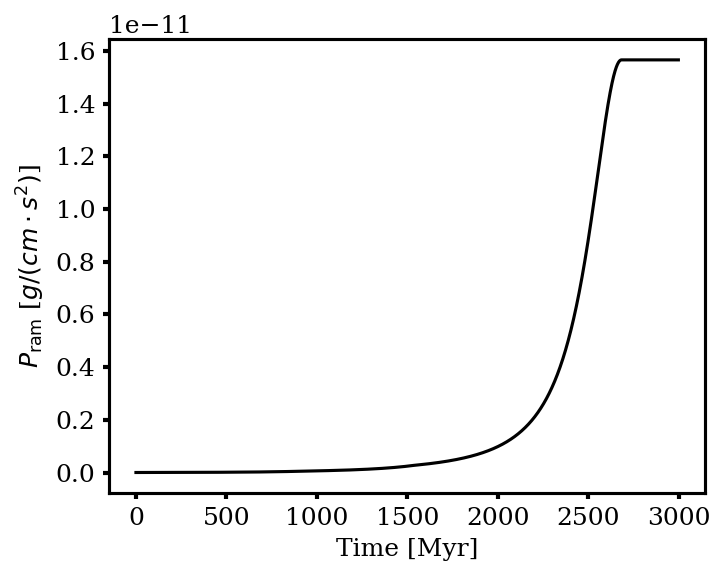

In [9]:
v_tot_with_units = v_tot * u.kpc / u.Myr
rho_with_units = rhos * u.g / u.cm**3

plt.figure(figsize=(5, 4),dpi=150)

plt.plot(ts, (rho_with_units * v_tot_with_units ** 2).to(u.g / u.cm / u.s**2), lw=1.5, color="black")
plt.xlabel("Time [Myr]")
plt.ylabel(r"$P_{\rm ram}$ [$g / (cm \cdot s^{2})$]")
plt.tight_layout()
plt.show()

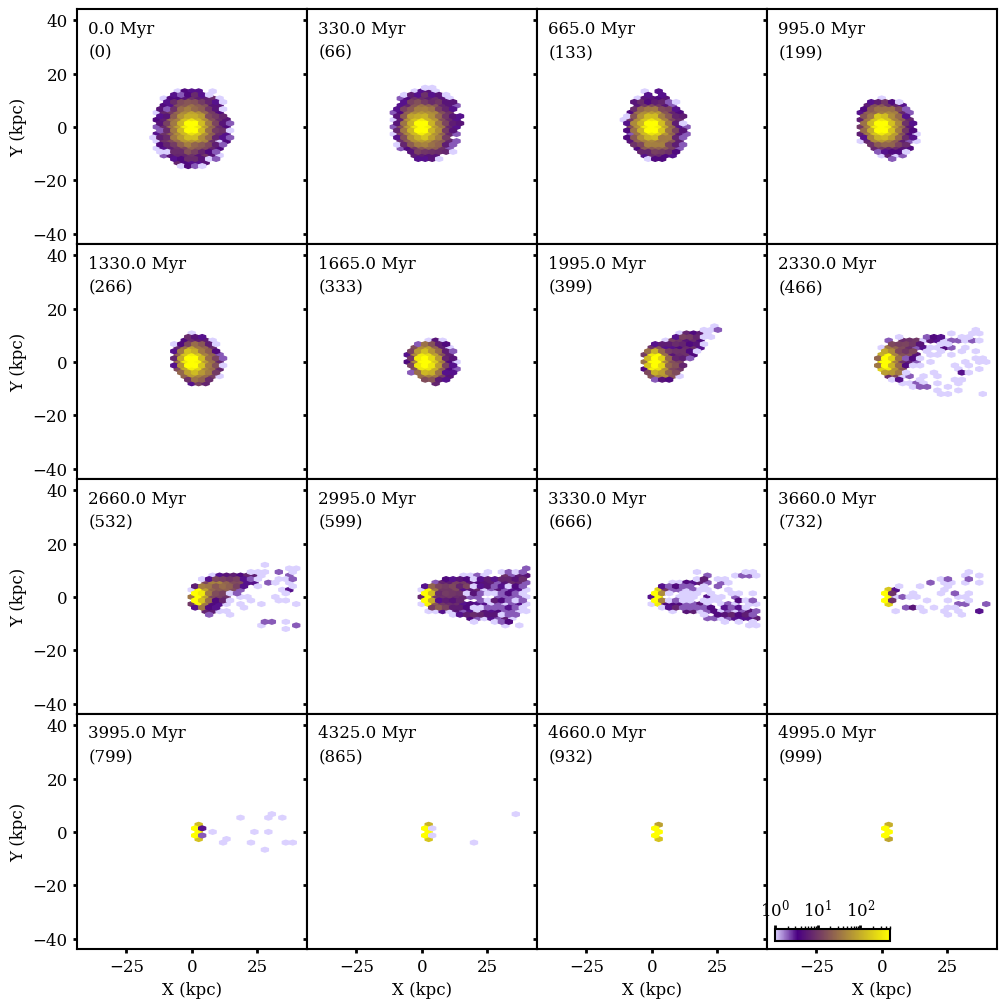

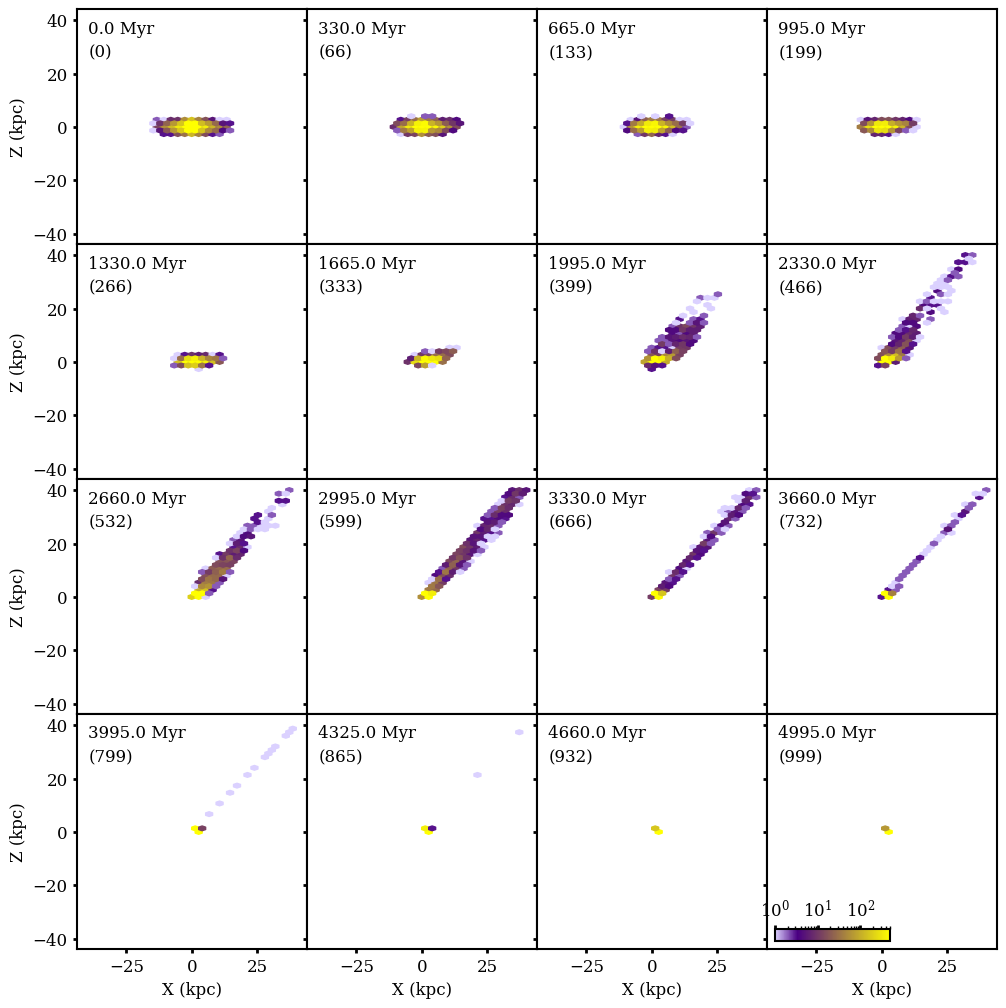

In [10]:
grp.density_matrix(orbits, cmap=cmap, outname="figures/density_matrix_JZ_dup_xy.png")
grp.density_matrix(orbits, cmap=cmap, y_ind=2, ylabel='Z (kpc)', outname="figures/density_matrix_JZ_dup_xz.png")

In [10]:
# grp.k3d_plot([orbits], outname="temp/orbits_JZ_dup.html", duration=120)

orbits.save("temp/orbits_JZ_dup.grp")